In [1]:

# 1. Packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm

In [2]:
# 2. Data
data = pd.read_excel("Quant_IV.xlsx",header=1, usecols="A:H")
data = data[['Y', 'X', 'Z']]
data.head()

,Y,X,Z
0,8.39,6.50,4.359270
1,7.77,5.36,5.634790
2,9.13,6.39,4.232656
3,9.90,9.32,2.145931
4,9.29,7.50,4.442651


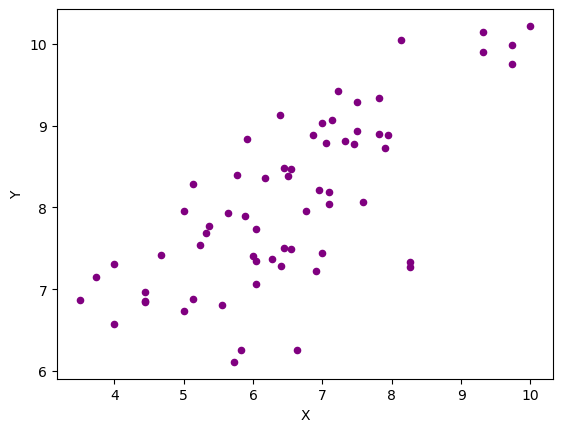

In [3]:
##Plotting the relationship between X and Y
#we can observe a strongly positive relationship between x='X' & y='Y'
data.plot(x='X', y='Y', kind='scatter', color='purple')
plt.show()

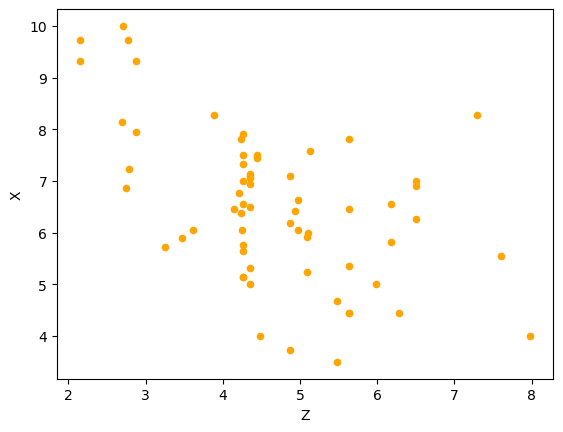

In [4]:
##Plotting the relationship between 'Z' and 'X' to see if 'X' may be an endogenous variable!
#we can observe a fairly negative relationship between 'Z' and 'X'.
data.plot(x='Z', y='X', kind='scatter', color='orange')
plt.show()

In [5]:
##2SLS model##

#We add a constant column with value 1 to the current data to make the true dimension(i.e., beta0*1=beta0)
data['const'] = 1

###FIRST STAGE regression model
reg_fs = sm.OLS(data['X'],
                    data[['const', 'Z']],
                    missing='drop').fit()
print(reg_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     23.34
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           9.27e-06
Time:                        11:04:56   Log-Likelihood:                -104.69
No. Observations:                  64   AIC:                             213.4
Df Residuals:                      62   BIC:                             217.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3659      0.611     15.339      0.0

In [6]:
###SECOND STAGE regression model

#we first need to retrive the residuals:
data['residual'] = reg_fs.resid

reg_ss = sm.OLS(data['X'],
                    data[['const', 'residual']],
                    missing='drop').fit()
print(reg_ss.summary())

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     164.7
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           4.14e-19
Time:                        11:04:56   Log-Likelihood:                -73.429
No. Observations:                  64   AIC:                             150.9
Df Residuals:                      62   BIC:                             155.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5161      0.097     67.320      0.0

In [7]:
print("""
According to the Hausman test, if variable 'X' and error term 'residual' are correlated, then we cannot accept the null hypothesis and variable 'X' is endogenous. 
we tested the null hypothesis and obtained the P-values. we can see that P-values are less than alpha=0.05 and so we cannot accept the null hypothesis 
(the coefficient of residual is significant and Z can help to explain differences in Y). 
it means that 'X' and 'residual' are not independent and variable 'X' is endogenous. thus, the traditional OLS cannot fit a correct model because it assumes 'X' and 'residual' are independent.
""")


According to the Hausman test, if variable 'X' and error term 'residual' are correlated, then we cannot accept the null hypothesis and variable 'X' is endogenous. 
we tested the null hypothesis and obtained the P-values. we can see that P-values are less than alpha=0.05 and so we cannot accept the null hypothesis 
(the coefficient of residual is significant and Z can help to explain differences in Y). 
it means that 'X' and 'residual' are not independent and variable 'X' is endogenous. thus, the traditional OLS cannot fit a correct model because it assumes 'X' and 'residual' are independent.



In [8]:
# Exogeneity
# TSLS

mdatac = sm.add_constant(data=data, prepend=False)

mlr2 = lm.IV2SLS(dependent=mdatac["Y"], exog=mdatac[['const']], endog=mdatac['X'], instruments=mdatac[['Z']]).fit(cov_type='homoskedastic', debiased=True)

In [9]:
# Wu-Hausman Tests
print(mlr2.wu_hausman())
print(mlr2.wooldridge_regression)

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 21.5601
P-value: 0.0000
Distributed: F(1,61)
Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 21.5601
P-value: 0.0000
Distributed: chi2(1)


In [10]:
# Sargan Over-identifying Restrictions Test
print(mlr2.sargan)

Invalid test statistic
Test requires more instruments than endogenous variables.
Sargan's test of overidentification
